**Part 1: Transformers**

**Task 1**

For this task I chose the CNN/DailyMail Dataset which contains news articles and human written summaries.

In [ ]:
!pip install transformers datasets rouge-score sacrebleu

In [ ]:
!pip install evaluate

Dataset Overview:
                                             article  \
0  LONDON, England (Reuters) -- Harry Potter star...   
1  Editor's note: In our Behind the Scenes series...   
2  MINNEAPOLIS, Minnesota (CNN) -- Drivers who we...   
3  WASHINGTON (CNN) -- Doctors removed five small...   
4  (CNN)  -- The National Football League has ind...   

                                          highlights  \
0  Harry Potter star Daniel Radcliffe gets £20M f...   
1  Mentally ill inmates in Miami are housed on th...   
2  NEW: "I thought I was going to die," driver sa...   
3  Five small polyps found during procedure; "non...   
4  NEW: NFL chief, Atlanta Falcons owner critical...   

                                         id  
0  42c027e4ff9730fbb3de84c1af0d2c506e41c3e4  
1  ee8871b15c50d0db17b0179a6d2beab35065f1e9  
2  06352019a19ae31e527f37f7571c6dd7f0c5da37  
3  24521a2abb2e1f5e34e6824e0f9e56904a2b0e88  
4  7fe70cc8b12fab2d0a258fababf7d9c6b5e1262a  

Train Set Size: 287113
Test Set

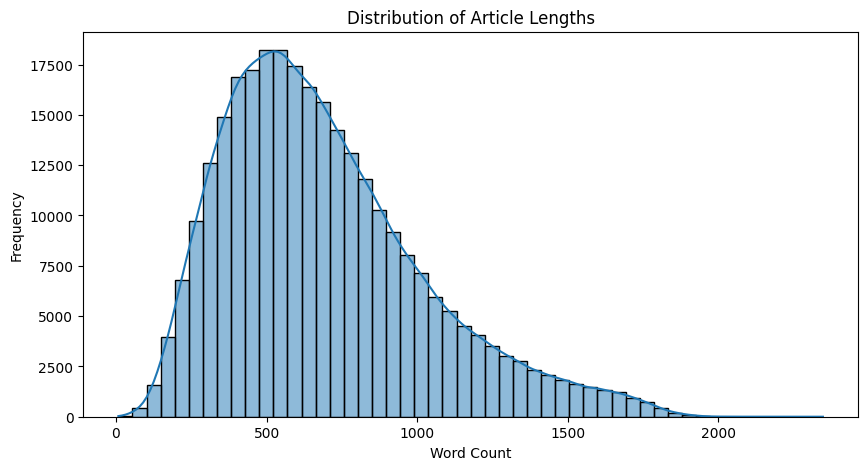

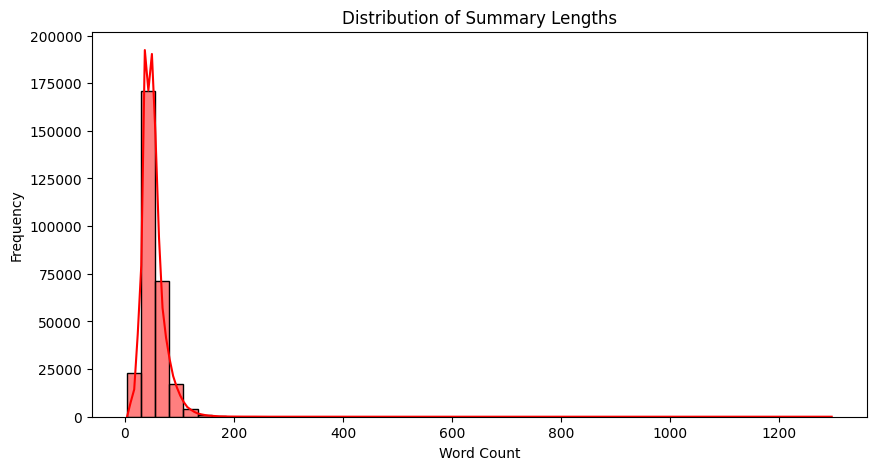


Average Article Length: 691.8703263175126
Average Summary Length: 51.574101486174435


In [3]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
dataset = load_dataset("cnn_dailymail", "3.0.0")
train_df = pd.DataFrame(dataset["train"])
test_df = pd.DataFrame(dataset["test"])

print("Dataset Overview:")
print(train_df.head())
print("Train Set Size:", len(train_df))
print("Test Set Size:", len(test_df))

print("Missing Values in Train Set:")
print(train_df.isnull().sum())

print("\nMissing Values in Test Set:")
print(test_df.isnull().sum())

train_df['article_length'] = train_df['article'].apply(lambda x: len(x.split()))
train_df['summary_length'] = train_df['highlights'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 5))
sns.histplot(train_df['article_length'], bins=50, kde=True)


plt.figure(figsize=(10, 5))
sns.histplot(train_df['summary_length'], bins=50, kde=True, color='red')

print("\nAverage Article Length:", train_df['article_length'].mean())
print("Average Summary Length:", train_df['summary_length'].mean())

In [1]:
import torch
from transformers import BartTokenizer, BartForConditionalGeneration, Trainer, TrainingArguments
from datasets import load_dataset
from evaluate import load as load_metric
import os

os.environ["WANDB_DISABLED"] = "true"

# Load CNN/DailyMail Dataset (Using a smaller subset for faster training)
dataset = load_dataset("cnn_dailymail", "3.0.0")
dataset["train"] = dataset["train"].select(range(5000))
dataset["test"] = dataset["test"].select(range(1000))

# Load Tokenizer
tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-cnn")

def preprocess_data(examples):
    inputs = tokenizer(examples["article"], max_length=256, truncation=True, padding="max_length")  # Reduced max_length
    labels = tokenizer(examples["highlights"], max_length=128, truncation=True, padding="max_length")
    inputs["labels"] = labels["input_ids"]
    return inputs

# Preprocess and split dataset with parallel processing
dataset = dataset.map(preprocess_data, batched=True, num_proc=4)
dataset_split = dataset["train"].train_test_split(test_size=0.1)
train_data = dataset_split["train"]
test_data = dataset_split["test"]


model = BartForConditionalGeneration.from_pretrained("facebook/bart-base")

# Define Training Arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=2,
    weight_decay=0.01,
    save_total_limit=2,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=test_data,
)

trainer.train()

# Evaluate using ROUGE and BLEU
rouge = load_metric("rouge")
bleu = load_metric("bleu")

def evaluate_model():
    predictions = trainer.predict(test_data)
    decoded_preds = tokenizer.batch_decode(predictions.predictions, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(test_data["labels"], skip_special_tokens=True)

    rouge_scores = rouge.compute(predictions=decoded_preds, references=decoded_labels)
    bleu_scores = bleu.compute(predictions=[p.split() for p in decoded_preds], references=[[r.split()] for r in decoded_labels])

    return rouge_scores, bleu_scores

rouge_results, bleu_results = evaluate_model()
print("ROUGE Scores:", rouge_results)
print("BLEU Score:", bleu_results)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map (num_proc=4):   0%|          | 0/5000 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/13368 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/1000 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss
1,No log,1.225632


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3353: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


KeyboardInterrupt: 

This code kept taking too long to run. It was during the training where it took too long. I also messed around with the epochs and dataset size to make it faster but it stil didn't seem to work.

**Part 2: Reinforcement Learning**

**Task 2**

A real-world application I will use for this task is autonomous vehicle navigation.

State Space:
The state space includes all relevant factors that define the environment of the vehicle.

*   The vehicles current postion
*   Speed/ acceleration
*   Which lane the vehicle is in
*   Distance to nearby vehicle or obstacles
*   Traffic signals and signs
*   Road/ weather conditions (wet, icy)

Action Space:
The action space includes all the possible decisions the autonomous vehicle  can make.

*   Acceleration (increase speed, maintain speed, decelerate.)
*   Steering (turn left, turn right, straight)
*   Lane Change (shift left, shift right, stay in lane)
*   Breaking (gradual braking, hard breaking and no break)

Transition Model:
The transition model defines how the vehicle moves from one state to anoter based on its current state and action.

*   How acceleration affects vehicle speed and postion
*   How lane change impacts vehicles relative postions to obstacles
*   How traffic conditions and signs influence movement

Reward:
Assigns a score to different outcomes to encourage optimal behavior

*   Positive Rewards (maintaining speed limits, following traffic rules, and reaching destination successfully)
*   Negative Rewards (collisions, sudden breaking, veering off road, violating traffic laws)
*   Small peenalties (unnecessary lane change or inefficient driving behavior)










**Task 3**

One of the significant problems in healthcare that can be solved using reinforcemnt learning is personalized treatment planning for diseases, such as diabetes managment or cancer treatment optimization. Traditional treatment strategies often follow a  "one size fits all" approach, whereas RL can dynamically learn and adapt personalized treatments based on patient reponses overtime.

[Open Source Project](https://github.com/matthieukomorowski/AI_Clinician): AI Clinician: reinforcement learning in intensive care"

This project introduces the AI Clinician, a reinforcement learning-based system that learns optimal sepsis treatment policies using real patient data from the MIMIC-III database.

How the AI Clinician Works
1. Dataset and Patirnt Data Extraction
  - The model is trained on MIMIC-III, which contains real patient records with vital signs, laboratory values, medications administered, survival outcomes
2. State Space
  - The state space includes includes features like mean arterial pressure, lactate concentration and organ dysfunction markers
  - This state vector encapsulates a patients condition at any given time step
3. Action Space
  - The RL agent selects one of 25 possible treatments, consisting of different combinations of IV dosages and vasopressor administration
4. Reward Function
  - Penalizes high mortality risk
  - Encourage survival by selecting actions that lead better to patient outcomes
  - It is trained using Off-Policy Q-Learning with a Deep Q-Network approach
5. Training and Evaluation
  - The AI clinician is trained using historical patient data, learning from past treatment outcomes
  - It is evaluated by comparing its recommendations to those made by human doctors
  - Results showed that the AI's suggested treatments closely matched those given to survivng patients, while differing significantly from treatments given to non-survivors

Impact of the AI Clinician
- Able to Learn optimal treatment policies beyond human intuition
- Helps reduce mortality rates by preventing suboptimal treatments
- Assists doctors by providing evidence-backed recommendation
- Has the potential be integrated into hospital ICUs for real-time decision-making.


**Part 3: Recommender Systems**

**Task 5**

EDA

In [ ]:
import numpy as np
import pandas as pd
from scipy.sparse.linalg import svds
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt, log2

# Load the MovieLens 100k dataset
column_names = ['user_id', 'item_id', 'rating', 'timestamp']
data = pd.read_csv('u.data', sep='\t', names=column_names)

print("Dataset shape:", data.shape)
print(data.head())

# Create train/test split
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
print("\nTrain shape:", train_data.shape)
print("Test shape:", test_data.shape)

# Get number of users and items
n_users = data['user_id'].max()
n_items = data['item_id'].max()
print("\nNumber of users:", n_users)
print("Number of items:", n_items)



Dataset shape: (100000, 4)
   user_id  item_id  rating  timestamp
0      196      242       3  881250949
1      186      302       3  891717742
2       22      377       1  878887116
3      244       51       2  880606923
4      166      346       1  886397596

Train shape: (80000, 4)
Test shape: (20000, 4)

Number of users: 943
Number of items: 1682


In [ ]:
train_matrix = np.zeros((n_users, n_items))
for row in train_data.itertuples():
    train_matrix[row.user_id - 1, row.item_id - 1] = row.rating

test_matrix = np.zeros((n_users, n_items))
for row in test_data.itertuples():
    test_matrix[row.user_id - 1, row.item_id - 1] = row.rating

# SVD
def svd_recommendation(train_matrix, k=20):

    U, sigma, Vt = svds(train_matrix, k=k)
    sigma = np.diag(sigma)
    pred_matrix = np.dot(np.dot(U, sigma), Vt)
    return pred_matrix

# Get SVD predictions
k = 20
svd_pred = svd_recommendation(train_matrix, k=k)

# ALS
def als(train_matrix, n_factors=20, n_iterations=10, reg=0.1):

    n_users, n_items = train_matrix.shape

    user_factors = np.random.rand(n_users, n_factors)
    item_factors = np.random.rand(n_items, n_factors)

    I = np.eye(n_factors)

    # ALS optimization loop
    for iteration in range(n_iterations):
        for u in range(n_users):

            item_idx = train_matrix[u, :] > 0
            if np.sum(item_idx) == 0:
                continue

            V = item_factors[item_idx, :]
            r_u = train_matrix[u, item_idx]

            A = V.T.dot(V) + reg * I
            b = V.T.dot(r_u)
            user_factors[u, :] = np.linalg.solve(A, b)

        for i in range(n_items):
            user_idx = train_matrix[:, i] > 0
            if np.sum(user_idx) == 0:
                continue
            U_sub = user_factors[user_idx, :]
            r_i = train_matrix[user_idx, i]
            A = U_sub.T.dot(U_sub) + reg * I
            b = U_sub.T.dot(r_i)
            item_factors[i, :] = np.linalg.solve(A, b)

    return user_factors, item_factors

# Run ALS on training data
n_factors = 20
n_iterations = 15
reg = 0.1
user_factors, item_factors = als(train_matrix, n_factors=n_factors, n_iterations=n_iterations, reg=reg)
als_pred = user_factors.dot(item_factors.T)

# Define RMSE evaluation function
def compute_rmse(pred, true):

    pred = pred[true.nonzero()].flatten()
    true = true[true.nonzero()].flatten()
    return sqrt(mean_squared_error(true, pred))

svd_rmse = compute_rmse(svd_pred, test_matrix)
print("\nSVD RMSE on test set: {:.4f}".format(svd_rmse))

als_rmse = compute_rmse(als_pred, test_matrix)
print("ALS RMSE on test set: {:.4f}".format(als_rmse))

# Evaluation Metric: nDCG
def dcg(relevances):

    return sum((2**rel - 1) / log2(idx + 2) for idx, rel in enumerate(relevances))

def ndcg_at_k(pred_scores, true_ratings, k=10, threshold=4):

    top_k_idx = np.argsort(pred_scores)[::-1][:k]

    relevances = [1 if true_ratings[i] >= threshold else 0 for i in top_k_idx]
    dcg_val = dcg(relevances)

    ideal_relevances = sorted([1 if r >= threshold else 0 for r in true_ratings], reverse=True)[:k]
    idcg_val = dcg(ideal_relevances)

    return dcg_val / idcg_val if idcg_val > 0 else 0.0

def average_ndcg(pred_matrix, test_matrix, k=10, threshold=4):
    n_users = test_matrix.shape[0]
    ndcg_list = []
    for u in range(n_users):
        if np.sum(test_matrix[u, :]) > 0:
            ndcg_val = ndcg_at_k(pred_matrix[u, :], test_matrix[u, :], k=k, threshold=threshold)
            ndcg_list.append(ndcg_val)
    return np.mean(ndcg_list)

# Evaluate nDCG for SVD and ALS predictions
svd_ndcg = average_ndcg(svd_pred, test_matrix, k=10, threshold=4)
als_ndcg = average_ndcg(als_pred, test_matrix, k=10, threshold=4)
print("SVD nDCG@10 on test set: {:.4f}".format(svd_ndcg))
print("ALS nDCG@10 on test set: {:.4f}".format(als_ndcg))



SVD RMSE on test set: 2.6432
ALS RMSE on test set: 1.4167

SVD nDCG@10 on test set: 0.0838
ALS nDCG@10 on test set: 0.0060

Summary of Results:
SVD: RMSE = 2.6432, nDCG@10 = 0.0838
ALS: RMSE = 1.4167, nDCG@10 = 0.0060


For this task I used Root Mean Squared Error (RMSE) an Normalized Discounted Cumulative Gain at k = 10 (nDCG@10). RMSE measures rating prediction accuracy, lower RMSE = better rating prediction. nDCG@10 measures ranking quality, higher nDCG@10 = better ranking of relevant items.

From the results above we can see that ALS RMSE is lower, thus ALS is better at predicting exact rating. On the other hand, SVD nDCG@10 is higher, thus SVD is better at ranking highly relevant items earlier in the recommendations.

Sources for evaluation metric:
[nDCG link](https://www.evidentlyai.com/ranking-metrics/ndcg-metric)
[nDCG link](https://github.com/kmbnw/rank_metrics/blob/master/python/ndcg.py)
[RMSE link](https://discovery.cs.illinois.edu/guides/Statistics-with-Python/rmse/#:~:text=The%20RMSE%2C%20or%20Root%20Mean,accuracy%20of%20a%20prediction%20model.)
[RMSE link](https://www.geeksforgeeks.org/step-by-step-guide-to-calculating-rmse-using-scikit-learn/)